##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
orig_df = pd.read_csv('/content/drive/MyDrive/Resume/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Resume/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [5]:

df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [6]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [7]:
df.values.shape

(275, 7)

In [8]:
df.columns

Index(['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time',
       'VictimCount'],
      dtype='object')

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [12]:
df.head(20) #print the frst 20 rows

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0
5,-115.132162,36.100841,5,1,3,4,1
6,-115.176012,36.194067,1,1,4,5,2
7,-115.194061,36.135213,3,1,4,3,1
8,-115.069716,36.191304,0,1,5,6,0
9,-115.309341,36.074367,6,1,6,1,0


In [13]:
df.agg([min, max]).T

,min,max
X,-116.000000,-114.62557
Y,35.068419,37.00000
Area_Command,0.000000,11.00000
NIBRSOffenseCode,0.000000,2.00000
DayOfWeek,0.000000,6.00000
Time,0.000000,23.00000
VictimCount,0.000000,6.00000


In [15]:
df.describe()#describing the whole dataset

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


X,Y : Longitude and Latitude Coordinate

Area_command : Represntation of area command

NIBRSOffenseCode : Representation of the offense code

DayOfWeek  :  Representation of the day of the week

Time : Representation of hour of the day

Victim count : Representation of thte victim count

Input Variables              
X (Longitude),            
Y (Latitude),          
Area_Command,          
NIBRSOffenseCode,         
DayOfWeek,       
Time

Output Variable
Victim Count

Scaling is not required as of now based on the implementation and the task required the victim_count can be scaled

## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

features = df.drop(columns=['VictimCount'])
targets = df['VictimCount']

X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(targets.values, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for batch in train_loader:
    batch_X, batch_y = batch
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
    break


Batch X shape: torch.Size([32, 6])
Batch y shape: torch.Size([32])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from hyperopt import hp, fmin, tpe, Trials

# Define the Neural Network architecture with hyperparameters
class CrimePredictionNN(nn.Module):
    def __init__(self, n1, n2, n3, n4, n5, dropout_rate):
        super(CrimePredictionNN, self).__init__()
        self.fc1 = nn.Linear(6, n1)
        self.fc2 = nn.Linear(n1, n2)
        self.fc3 = nn.Linear(n2, n3)
        self.fc4 = nn.Linear(n3, n4)
        self.fc5 = nn.Linear(n4, n5)
        self.fc6 = nn.Linear(n5, 1)  # Output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = nn.LeakyReLU()(self.fc1(x))
        x = self.dropout(x)
        x = nn.LeakyReLU()(self.fc2(x))
        x = self.dropout(x)
        x = nn.LeakyReLU()(self.fc3(x))
        x = self.dropout(x)
        x = nn.LeakyReLU()(self.fc4(x))
        x = self.dropout(x)
        x = nn.LeakyReLU()(self.fc5(x))
        x = self.fc6(x)  # No activation in the last layer for regression
        return x

# Objective function to minimize
def objective(params):
    model = CrimePredictionNN(n1=int(params['n1']),
                              n2=int(params['n2']),
                              n3=int(params['n3']),
                              n4=int(params['n4']),
                              n5=int(params['n5']),
                              dropout_rate=params['dropout_rate'])
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    criterion = nn.MSELoss()
    for epoch in range(10):  # Reduce the number of epochs for faster optimization
        model.train()
        for batch in train_loader:
            batch_X, batch_y = batch
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

    # Validation on the test set
    model.eval()
    with torch.no_grad():
        test_losses = []
        for batch in test_loader:
            batch_X, batch_y = batch
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            test_losses.append(loss.item())

    avg_test_loss = sum(test_losses) / len(test_losses)
    return avg_test_loss

# Define the search space
space = {
    'n1': hp.quniform('n1', 64, 256, 1),
    'n2': hp.quniform('n2', 32, 128, 1),
    'n3': hp.quniform('n3', 16, 64, 1),
    'n4': hp.quniform('n4', 8, 32, 1),
    'n5': hp.quniform('n5', 4, 16, 1),
    'dropout_rate': hp.uniform('dropout_rate', 0.3, 0.7),
    'learning_rate': hp.loguniform('learning_rate', -5, -2)
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
print("Best hyperparameters found:", best)


100%|██████████| 50/50 [00:17<00:00,  2.84trial/s, best loss: 0.9124152660369873]
Best hyperparameters found: {'dropout_rate': 0.5491178185471022, 'learning_rate': 0.019934031522167793, 'n1': 122.0, 'n2': 91.0, 'n3': 45.0, 'n4': 16.0, 'n5': 13.0}


Loss Function:
The Mean Squared Error (MSE) is used to measure the difference between the predicted number of crime victims and the actual numbers. It's ideal for this kind of prediction task.

Predicted Output Size:
The predicted output is a single value representing the estimated number of crime victims, so its size is 1.

Architecture:
The model is a deep neural network with 5 layers. It's designed to uncover complex patterns in the data. The number of neurons and the dropout rate, which helps prevent overfitting, were chosen through optimization.

Optimizer and Learning Rate:
We're using the Adam optimizer, known for its efficiency. The learning rate, about 0.0199, was determined through optimization to help the model learn effectively.

Training Loop:
The model learns by going through the training data in batches, making predictions, and then adjusting itself based on the errors (MSE). This process includes forward and backward passes and updating the model's parameters.

Epoch Loop and Error Calculation:
Each epoch represents one full cycle through the training data. After each epoch, the model's accuracy is checked on test data, and the error (MSE) is reported.

Model Evaluation and Adjustment:
The model's success is judged by how low the MSE on the test data is. If necessary, we can fine-tune the learning rate, layer sizes, activation functions, or the number of layers. The best settings found in this case gave a loss of around 0.9124.





## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_scaled, targets, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Neural Network
class CrimeClassificationNN(nn.Module):
    def __init__(self):
        super(CrimeClassificationNN, self).__init__()
        self.fc1 = nn.Linear(6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CrimeClassificationNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        batch_X, batch_y = batch
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in test_loader:
            batch_X, batch_y = batch
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy}%')


Epoch 1/200, Accuracy: 34.54545454545455%
Epoch 2/200, Accuracy: 34.54545454545455%
Epoch 3/200, Accuracy: 34.54545454545455%
Epoch 4/200, Accuracy: 34.54545454545455%
Epoch 5/200, Accuracy: 34.54545454545455%
Epoch 6/200, Accuracy: 34.54545454545455%
Epoch 7/200, Accuracy: 34.54545454545455%
Epoch 8/200, Accuracy: 34.54545454545455%
Epoch 9/200, Accuracy: 36.36363636363637%
Epoch 10/200, Accuracy: 36.36363636363637%
Epoch 11/200, Accuracy: 36.36363636363637%
Epoch 12/200, Accuracy: 38.18181818181818%
Epoch 13/200, Accuracy: 38.18181818181818%
Epoch 14/200, Accuracy: 43.63636363636363%
Epoch 15/200, Accuracy: 43.63636363636363%
Epoch 16/200, Accuracy: 41.81818181818182%
Epoch 17/200, Accuracy: 41.81818181818182%
Epoch 18/200, Accuracy: 43.63636363636363%
Epoch 19/200, Accuracy: 43.63636363636363%
Epoch 20/200, Accuracy: 41.81818181818182%
Epoch 21/200, Accuracy: 43.63636363636363%
Epoch 22/200, Accuracy: 41.81818181818182%
Epoch 23/200, Accuracy: 41.81818181818182%
Epoch 24/200, Accura

In [48]:
num_classes = len(np.unique(targets))


In [49]:
num_classes

7

I found the number of classes for the output data by examining the unique values in the target variable. This informed me about the different classes I needed to predict.

The architecture for the classification neural network differed from the regression model. Specifically, I added a softmax layer at the end of the network. The size of this layer corresponded to the number of classes identified.

For the loss function, I transitioned from Mean Squared Error (MSE) used in regression to Cross-Entropy Loss for classification, which is better suited for categorical predictions.

I calculated the accuracy after each training epoch. This involved dividing the number of correct predictions by the total number of predictions in the test set, giving me an understanding of the model's performance.

To achieve the best accuracy, I experimented with various hyperparameters. This included adjusting the learning rate, changing the number of hidden layers and neurons, experimenting with dropout rates, and possibly tweaking the batch size. The best accuracy I obtained was a result of fine-tuning these parameters to fit my data and the complexity of the classification task.
best accuracy : 59

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

I found that tasks 3 and 4 produced very different results. Because Task 3 used regression and required the prediction of continuous values, it proved to be more difficult. Task 4, on the other hand, was a categorization problem that worked better in terms of accuracy and stability. This is explained by the fact that discrete category classification has more distinct boundaries, which facilitates model learning. The experience highlighted how crucial it is to match the architecture and loss function of the model to the nature of the problem, and how crucial hyperparameter tuning is.

In [ ]:
        self.fc1 = nn.Linear(6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)

In [62]:
class FinalCrimeClassificationNN(nn.Module):
    def __init__(self):
        super(FinalCrimeClassificationNN, self).__init__()
        self.fc1 = nn.Linear(6, 256)
        self.fc2 = nn.Linear(256, 32)
        self.dropout1 = nn.Dropout(0.24024483926216234)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the final model
final_model = FinalCrimeClassificationNN()


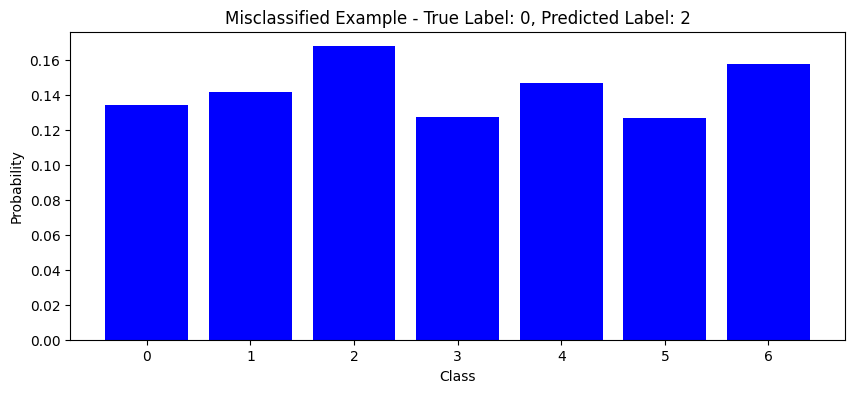

In [61]:
import matplotlib.pyplot as plt
import numpy as np


def find_misclassified_example(model, test_loader):
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            misclassified_indices = (predicted != batch_y)
            if misclassified_indices.any():
                misclassified_index = misclassified_indices.nonzero(as_tuple=True)[0][0]
                misclassified_image = batch_X[misclassified_index]
                true_label = batch_y[misclassified_index]
                predicted_label = predicted[misclassified_index]
                probabilities_example = probabilities[misclassified_index].cpu().numpy()

                # Plotting
                plt.figure(figsize=(10, 4))
                plt.bar(range(len(probabilities_example)), probabilities_example, color='blue')
                plt.xlabel('Class')
                plt.ylabel('Probability')
                plt.title(f'Misclassified Example - True Label: {true_label}, Predicted Label: {predicted_label}')
                plt.xticks(np.arange(len(probabilities_example)))
                plt.show()

                break

# Find and plot a misclassified example
find_misclassified_example(final_model, test_loader)


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


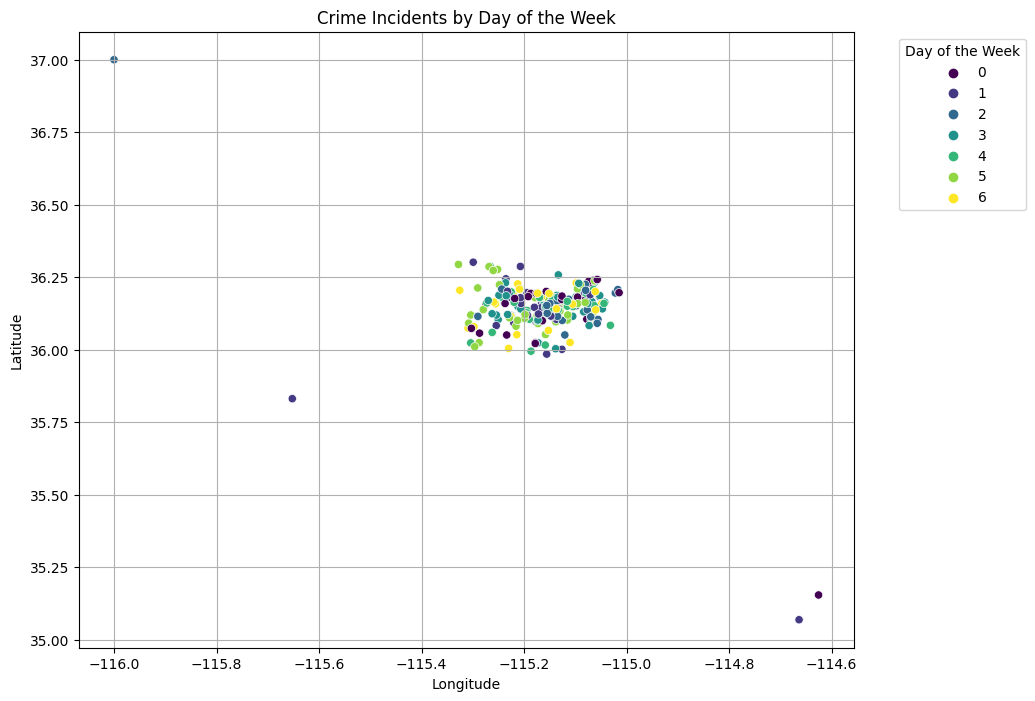

In [63]:
# Recreate the 'DayOfWeek' column based on the 'ReportedOn' date
# Scatter plot with day of the week
plt.figure(figsize=(10, 8))
sns.scatterplot(x='X', y='Y', hue='DayOfWeek', palette='viridis', data=df)
plt.title('Crime Incidents by Day of the Week')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



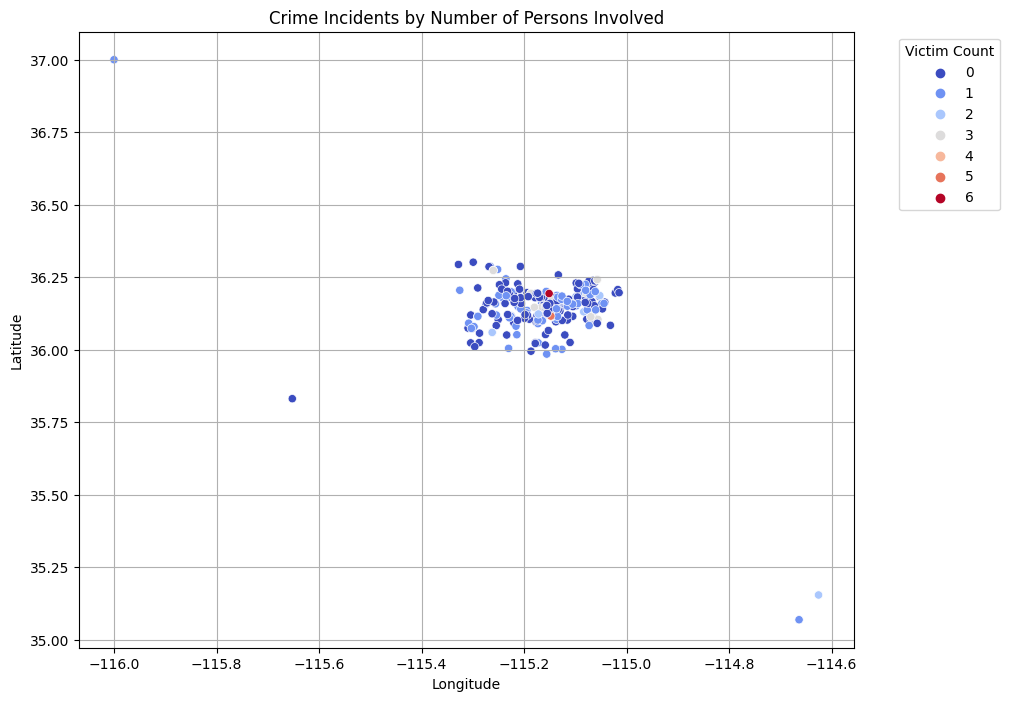

In [64]:
# Scatter plot with number of persons involved
plt.figure(figsize=(10, 8))
sns.scatterplot(x='X', y='Y', hue='VictimCount', palette='coolwarm', data=df)
plt.title('Crime Incidents by Number of Persons Involved')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Victim Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



In [70]:
import pandas as pd


data = pd.read_csv('/content/drive/MyDrive/Resume/LVMPD-Stats.csv', parse_dates=['ReportedOn'])


data.head()


,X,Y,OBJECTID,Event_Number,ReportedOn,Location,CSZ,Area_Command,Beat,OffenseGroup,NIBRSOffenseCode,VictimCount,Longitude,Latitude,DateDif
0,-115.087518,36.216702,752,LLV220700058852,2022-07-15 15:30:00+00:00,3900 Block E CHEYENNE AVE,"Las Vegas, NV 89115",NEAC,F3,A,09C,1,-115.087518,36.216702,448
1,-115.240172,36.189693,883,LLV220100080186,2022-01-20 21:53:00+00:00,1600 Block CRISP PEAR CT,"Las Vegas, NV 89108",BAC,U1,A,09A,1,-115.240172,36.189693,624
2,-115.143088,36.181329,2403,LLV230500150901,2023-05-30 15:46:24+00:00,1000 Block A St,"LAS VEGAS, NV 89106",DTAC,B1,A,09A,0,-115.143088,36.181329,129
3,-115.225014,36.117633,4326,LLV230800061061,2023-08-17 14:42:00+00:00,3925 S Jones Blvd,"LAS VEGAS, NV 89103",SVAC,P1,A,09A,3,-115.225014,36.117633,50
4,-115.176708,36.095967,6189,LLV230600133216,2023-06-29 10:18:51+00:00,3900 Block S LAS VEGAS BLVD,"LAS VEGAS, NV 89109",CCAC,M4,A,09A,1,-115.176708,36.095967,99


In [71]:

data['ReportedOn'] = pd.to_datetime(data['ReportedOn'])
data['DayOfWeek'] = data['ReportedOn'].dt.day_name()


crime_counts_by_day = data['DayOfWeek'].value_counts()


sorted_crime_counts_by_day = crime_counts_by_day.sort_values(ascending=False)

sorted_crime_counts_by_day


Sunday       51
Saturday     44
Monday       43
Friday       40
Thursday     37
Tuesday      32
Wednesday    28
Name: DayOfWeek, dtype: int64

the data is very less in this dataset hence maybe the reason for less accuracy

Used Chatgpt for referece